#### In this notebook, we validate the R/Spark operations by comparing them against vanilla R operations on a smaller subset of the data

#### Spark

[1] "/home/lngo/git/workshop-r-spark-big-data"

[1] "Package is loaded"
[1] "Package is loaded"
[1] "Package is loaded"
[1] "Package is loaded"


Re-using existing Spark connection to yarn


DayOfWeek,avg_depdelay,avg_arrdelay
1,10.242308,9.204499
2,8.343784,7.565824
3,9.787072,9.549507
4,13.184082,13.263061
5,15.403417,15.520910
6,9.298658,6.520653
7,12.513803,11.285020


     year            avg_depdelay     avg_arrdelay   
 Length:41          Min.   : 4.737   Min.   : 2.713  
 Class :character   1st Qu.: 7.972   1st Qu.: 6.456  
 Mode  :character   Median :10.382   Median : 8.692  
                    Mean   :10.035   Mean   : 8.481  
                    3rd Qu.:11.310   3rd Qu.:10.344  
                    Max.   :21.359   Max.   :17.083  

year,delay_type,delay_time
1956,avg_depdelay,21.359223
1959,avg_depdelay,10.877485
1962,avg_depdelay,9.941834
1963,avg_depdelay,10.692406
1964,avg_depdelay,11.310345
1965,avg_depdelay,6.283111


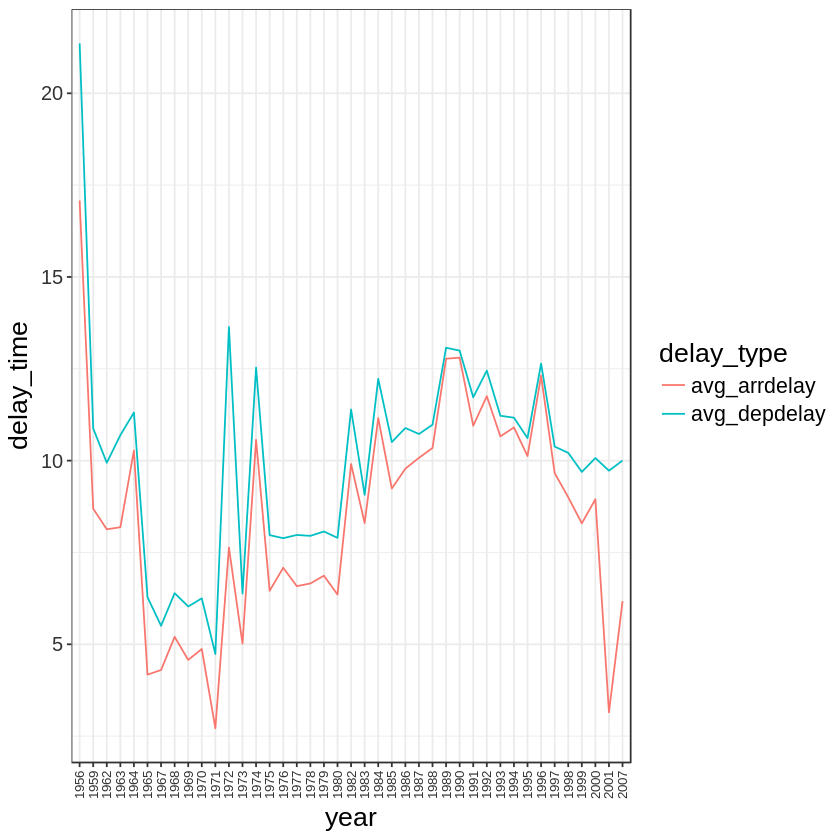

In [61]:
getwd()
rm(list = ls())

# setup sparklyr
setupLibrary <- function(libraryName){
  if (!require(libraryName, character.only = TRUE)){
    install.packages(libraryName, dep = TRUE)
    if (!require(libraryName, character.only = TRUE)){
      print('Package not found')
    }
  } else {
    print('Package is loaded')
  }
}

setupLibrary('sparklyr')
setupLibrary('dplyr')
setupLibrary('ggplot2')  
setupLibrary('reshape2')

# setup spark cluster
sc <- spark_connect(master = 'yarn', 
                    config = list('spark.driver.memory'='8G',
                                  'spark.executor.instances'=4,
                                  'spark.executor.cores'=8,
                                  'spark.executor.memory'='8G'))

# load one data file from airline dataset
airline_tlb <- spark_read_csv(sc, name = 'airline_data',
                              path = '/repository/airlines/data/2000.csv',
                              delimiter = ',')

# Average delay during different day of week
delay_timeofday <- airline_tlb %>% 
  mutate(numeric_depdelay = as.numeric(DepDelay)) %>%
  mutate(numeric_arrdelay = as.numeric(ArrDelay)) %>%
  group_by(DayOfWeek) %>%
  summarize(avg_depdelay = mean(numeric_depdelay),
           avg_arrdelay = mean(numeric_arrdelay)) %>%
  collect            

delay_timeofday[order(delay_timeofday$DayOfWeek),]

# Do older planes suffer more delays?
planes_tlb <- spark_read_csv(sc, name = 'plane_data',
                              path = '/repository/airlines/metadata/plane-data.csv',
                              delimiter = ',')

clean_planes_tlb <- planes_tlb %>%
  filter(!is.na(year))

planes_year <- airline_tlb %>%
  mutate(numeric_depdelay = as.numeric(DepDelay)) %>%
  mutate(numeric_arrdelay = as.numeric(ArrDelay)) %>%
  select(TailNum, numeric_depdelay, numeric_arrdelay) %>%
  inner_join(clean_planes_tlb, by = c('TailNum' = 'tailnum')) %>%
  select(year, numeric_depdelay, numeric_arrdelay)

avg_delay_planes_year <- planes_year %>%
  group_by(year) %>%
  summarize(avg_depdelay = mean(numeric_depdelay),
           avg_arrdelay = mean(numeric_arrdelay)) %>%
  filter(year != 'None') %>%
  collect

summary(avg_delay_planes_year)

# draw the plot
avg_delay_planes_year <- melt(avg_delay_planes_year, id.vars="year", 
                              variable.name = 'delay_type', 
                              value.name = 'delay_time')
avg_delay_planes_year$delay_type <- as.character(avg_delay_planes_year$delay_type)

head(arrange(avg_delay_planes_year, desc(avg_delay_planes_year$delay_type), avg_delay_planes_year$year))

ggplot(data = avg_delay_planes_year, 
       aes(x = year, y = delay_time, group = delay_type, colour = delay_type)) +
    geom_line() + theme_bw() +
    theme(axis.text.x = element_text(colour="grey20", size=8, angle=90, hjust=.5, vjust=.5),
                        axis.text.y = element_text(colour="grey20", size=12),
          text=element_text(size=16, family="Arial"))

spark_disconnect(sc)

#### Vanilla R

[1] "/home/lngo/git/workshop-r-spark-big-data"

[1] "Package is loaded"
[1] "Package is loaded"
[1] "Package is loaded"


Warning message:
“running command ''hdfs' dfs -get /repository/airlines/data/2000.csv 2>&1' had status 1”

[1] "get: `2000.csv': File exists"
attr(,"status")
[1] 1
attr(,"errmsg")
[1] "Resource temporarily unavailable"

[1] "==================="


DayOfWeek,avg_depdelay,avg_arrdelay
1,10.178850,9.204499
2,8.288672,7.565824
3,9.723138,9.549507
4,13.091899,13.263061
5,15.293500,15.520910
6,9.246962,6.520653
7,12.430441,11.285020


Warning message:
“running command ''hdfs' dfs -get /repository/airlines/metadata/plane-data.csv 2>&1' had status 1”

[1] "get: `plane-data.csv': File exists"
attr(,"status")
[1] 1
attr(,"errmsg")
[1] "Resource temporarily unavailable"

     year            avg_depdelay     avg_arrdelay   
 Length:41          Min.   : 4.705   Min.   : 2.713  
 Class :character   1st Qu.: 7.949   1st Qu.: 6.456  
 Mode  :character   Median :10.342   Median : 8.692  
                    Mean   : 9.973   Mean   : 8.481  
                    3rd Qu.:11.172   3rd Qu.:10.344  
                    Max.   :21.359   Max.   :17.083  

year,delay_type,delay_time
1956,avg_depdelay,21.359223
1959,avg_depdelay,10.590891
1962,avg_depdelay,9.973822
1963,avg_depdelay,10.746949
1964,avg_depdelay,11.117323
1965,avg_depdelay,6.113764


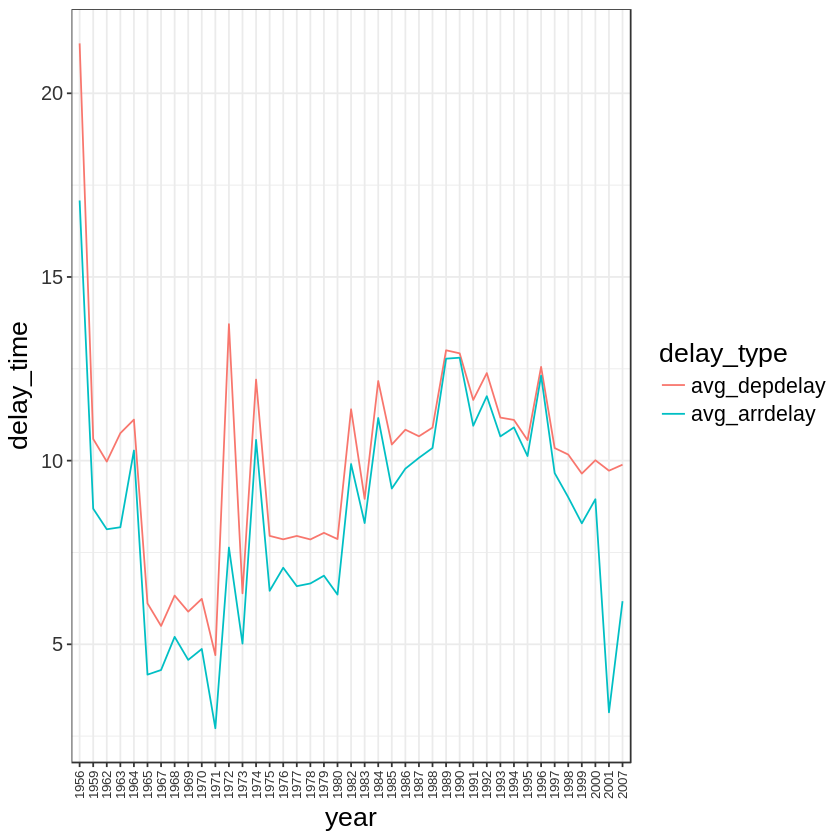

In [39]:
getwd()
rm(list = ls())

# setup libraries
setupLibrary <- function(libraryName){
  if (!require(libraryName, character.only = TRUE)){
    install.packages(libraryName, dep = TRUE)
    if (!require(libraryName, character.only = TRUE)){
      print('Package not found')
    }
  } else {
    print('Package is loaded')
  }
}

setupLibrary('dplyr')
setupLibrary('ggplot2')  
setupLibrary('reshape2')

# get data from HDFS
system2('hdfs',args = c('dfs','-get','/repository/airlines/data/2000.csv'), stderr = TRUE, stdout = TRUE)
print('===================')

# load one data file from airline dataset
airline_tlb <- read.csv('2000.csv', stringsAsFactors=FALSE)

# Average delay during different day of week
delay_timeofday <- airline_tlb %>%
  filter(!is.na(DepDelay)) %>%
  filter(!is.na(ArrDelay)) %>%
  group_by(DayOfWeek) %>%
  summarize(avg_depdelay = mean(DepDelay),
           avg_arrdelay = mean(ArrDelay))

delay_timeofday

# Do older planes suffer more delays?
system2('hdfs',args = c('dfs','-get','/repository/airlines/metadata/plane-data.csv'), stderr = TRUE, stdout = TRUE)
planes_tlb <- read.csv('plane-data.csv',stringsAsFactors=FALSE)

clean_planes_tlb <- planes_tlb %>%
  filter(year != '')

planes_year <- airline_tlb %>%
  filter(!is.na(DepDelay)) %>%
  filter(!is.na(ArrDelay)) %>%
  select(TailNum, DepDelay, ArrDelay) %>%
  inner_join(clean_planes_tlb, by = c('TailNum' = 'tailnum')) %>%
  select(year, DepDelay, ArrDelay)

avg_delay_planes_year <- planes_year %>%
  group_by(year) %>%
  summarize(avg_depdelay = mean(DepDelay),
           avg_arrdelay = mean(ArrDelay)) %>%
  filter(year != 'None') 

summary(avg_delay_planes_year)

# draw the plot
avg_delay_planes_year <- melt(avg_delay_planes_year, id.vars="year", variable.name = 'delay_type', value.name = 'delay_time')
head(avg_delay_planes_year)

ggplot(data = avg_delay_planes_year, 
       aes(x = year, y = delay_time, group = delay_type, colour = delay_type)) +
    geom_line() + theme_bw() +
    theme(axis.text.x = element_text(colour="grey20", size=8, angle=90, hjust=.5, vjust=.5),
                        axis.text.y = element_text(colour="grey20", size=12),
          text=element_text(size=16, family="Arial"))